[<img src="../../header.svg">](../index.ipynd)

---

# Drug Transport across a Virtual Skin Membrane:  Extended version
We know the basic steps from the [previous version](SkinDiffusion.ipybnd).

## 1. Setup

### Load existing modules 

In [27]:
import ug4py.pyugcore  as ugcore
import ug4py.pylimex as limex
import ug4py.pyconvectiondiffusion as cd
# import pysuperlu as slu


In [28]:
# Importing
import sys
sys.path.append('..')
import modsimtools as util

### Create Domain

In [29]:
requiredSubsets = {"LIP", "COR", "BOTTOM_SC", "TOP_SC"}
gridName = "skin2d-aniso.ugx"
numRefs = 2

In [30]:
dom = util.CreateDomain(gridName, numRefs, requiredSubsets)

Loading Domain 'skin2d-aniso.ugx'...
Domain loaded.
Refining ...
Refining step {0} ...
Refining step {1} ...
Refining done


### Create Approximation space

In [31]:
approxSpaceDesc = dict(fct = "u", type = "Lagrange", order = 1)
approxSpace = util.CreateApproximationSpace(dom, approxSpaceDesc)

Approximation space:
| ----------------------------------------------------------------------------------------- |
|  Number of DoFs (All Procs)                                                               |
|  Algebra: Block 1 (divide by 1 for #Index)                                                |
|                                                                                           |
|    GridLevel   |       Domain |       0: LIP |       1: COR | 2: BOTTOM_SC |    3: TOP_SC |
| ----------------------------------------------------------------------------------------- |
| (lev,    0)    |          680 |           32 |          608 |           20 |           20 |
| (lev,    1)    |         2613 |          783 |         1752 |           39 |           39 |
| (lev,    2)    |        10241 |         4367 |         5720 |           77 |           77 |
| (lev,    0, g) |          680 |           32 |          608 |           20 |           20 |
| (lev,    1, g) |         2613 |      

### Create spatial discretization

In [32]:
# Define model parameter
K={ "COR": 1e-3, "LIP": 1.0 }
D={ "COR":  1.0, "LIP":1.0 }

In [33]:
# Create element discretizations for lipids and corneocytes.
elemDisc ={}
elemDisc["COR"] = util.CreateDiffusionElemDisc("u", "COR", K["COR"], K["COR"]*D["COR"], 0.0)
elemDisc["LIP"] = util.CreateDiffusionElemDisc("u", "LIP", K["LIP"], K["LIP"]*D["LIP"], 0.0)

In [34]:
# Set Dirichlet boundary conditions.
dirichletBnd = ugcore.DirichletBoundary2dCPU1()
dirichletBnd.add(1.0, "u", "TOP_SC")
dirichletBnd.add(0.0, "u", "BOTTOM_SC")

In [35]:
# Create the global spatial discretization object.
domainDisc = ugcore.DomainDiscretization2dCPU1(approxSpace)
domainDisc.add(elemDisc["LIP"])
domainDisc.add(elemDisc["COR"])
domainDisc.add(dirichletBnd)

## 2. Steady state problem
Flux is computed from steady state. Since configuration of a multigrid solver is somewhat tricky, we use an LU decomposition here:

In [36]:
A = ugcore.AssembledLinearOperatorCPU1(domainDisc)
u = ugcore.GridFunction2dCPU1(approxSpace)
b = ugcore.GridFunction2dCPU1(approxSpace)

ugcore.Interpolate(0.0, u, "u")

domainDisc.assemble_linear(A, b)
domainDisc.adjust_solution(u)

lsolver = ugcore.LUCPU1()
#lsolver =slu.SuperLUCPU1()

lsolver.init(A, u)
lsolver.apply(u, b)

ugcore.WriteGridFunctionToVTK(u, "vtk/SkinSteadyState.vtk")


ILUT: please use 'set_ordering_algorithm(..)' in the future


Compute $J_\infty=J(t=\infty)$ for
$$ J(t)=\frac{1}{|\Gamma|}\int_\Gamma (-KD \nabla u(t,x)) \cdot \vec n dA$$

In [37]:
areaG=ugcore.Integral(1.0, u, "BOTTOM_SC")
print("Surface area [um^2]:")
print(areaG)

surfaceFlux = {}
surfaceFlux["BOT"] = K["LIP"]*D["LIP"]*ugcore.IntegrateNormalGradientOnManifold(u, "u", "BOTTOM_SC", "LIP")
surfaceFlux["TOP"] = K["LIP"]*D["LIP"]*ugcore.IntegrateNormalGradientOnManifold(u, "u", "TOP_SC", "LIP")

print("Surface fluxes [kg/s]:")
print(surfaceFlux["TOP"])
print(surfaceFlux["BOT"])

Surface area [um^2]:
30.100000000000016
IntegrateSubsets for subsets=BOTTOM_SC
Surface fluxes [kg/s]:
-0.0030822575664210083
0.0030822575668487456


In [38]:
print("Normalized Fluxes [kg / (mu^2 * s)]:")
print(surfaceFlux["TOP"]/areaG)
print(surfaceFlux["BOT"]/areaG)


Normalized Fluxes [kg / (mu^2 * s)]:
-0.00010240058360202681
0.00010240058361623734


In [39]:
Jref = 1.0/17.6

print("Relative Fluxes [1]:")
print(surfaceFlux["TOP"]/areaG/Jref)
print(surfaceFlux["BOT"]/areaG/Jref)

Relative Fluxes [1]:
-0.0018022502713956718
0.001802250271645777


## 3. Transient problem

### Define time integrator

In [40]:
# Create time discretization.
timeDisc=ugcore.ThetaTimeStepCPU1(domainDisc, 1.0) 

In [41]:
# Settings for time stepping.
startTime = 0.0
endTime = 5000.0
dt=25.0
dtMin=2.5

In [42]:
# Create time integrator.
timeInt = limex.ConstStepLinearTimeIntegrator2dCPU1(timeDisc)
timeInt.set_linear_solver(lsolver)
timeInt.set_time_step(dt)

###  Creating observers

After each successful step, we would like to perform certain operations, e.g. for book-keeping. To that end, we would like to execute the following callback `MyPostProcess`. In this function, print the solution and compute
$$
m(t_k):= \int_0^{t_k} J(s) \, ds \approx \sum_{i=1}^k(t_{i}- t_{i-1}) \frac{J(t_{i-1}) +J(t_i)}{2} 
$$
using the trapezoid rule. Moreover, we also compute the lag time $\tau$ from $m(t_k) = J_\infty(t_k - \tau)$.

In [43]:
# auxiliary variables for book-keeping
import numpy as np

tPoints = np.array([0.0])
mPoints = np.array([0.0])
jPoints = np.array([0.0])

def MyPostProcess(u, step, time, dt):
    
    global tPoints
    global mPoints
    global jPoints 
    
    tOld = tPoints[-1]
    mOld = mPoints[-1]
    jOld = jPoints[-1]
    
    # 1) Compute fluxes.
    gradFlux={}
    gradFlux["BOT"] = ugcore.IntegrateNormalGradientOnManifold(u, "u", "BOTTOM_SC", "LIP")
    gradFlux["TOP"] = ugcore.IntegrateNormalGradientOnManifold(u, "u", "TOP_SC", "LIP")
  
    jTOP = K["LIP"]*D["LIP"]*gradFlux["TOP"]
    jBOT = K["LIP"]*D["LIP"]*gradFlux["BOT"]
    print ("flux_top (\t" + str(time) + "\t)=\t" + str(jTOP))
    print ("flux_bot (\t" + str(time) + "\t)=\t" + str(jBOT))
  
    # 2) Compute mass.
    dt = time - tOld
    mass = mOld + (time - tOld)*(jBOT + jOld)/2.0
    print("mass_bot (\t"+ str(time) +"\t)=\t"+ str(mass))
  
    # 3) Compute lag time.
    print("tlag="+ str(time - mass/jBOT) )
  
    # 4) Updates
    tPoints = np.append(tPoints, time)
    jPoints = np.append(jPoints, jBOT)
    mPoints = np.append(mPoints, mass)


In [44]:
# We use this function to define a callback
pyobserver= ugcore.PythonCallbackObserver2dCPU1(MyPostProcess)

A second observer is used for writing vtk files:

In [45]:
# Create callback observer for file I/O.
def MyVTKCallback(usol, step, time, dt) :
    ugcore.WriteGridFunctionToVTK(usol, "vtk/SkinDiffusion_"+str(int(step)).zfill(5)+".vtu")
    
vtkobserver = ugcore.PythonCallbackObserver2dCPU1(MyVTKCallback) 

In [46]:
# Alternative:
# vtk=ug4.VTKOutput2d()
# vtkobserver=limex.VTKOutputObserver2dCPU1("../../SkinData.vtu", vtk)

The third  observer (for convenience, non-essential) indicates the progress of time stepping:

In [47]:
# Create progress widget.
import ipywidgets as widgets
from IPython.display import display

wProgress=widgets.FloatProgress(value=startTime, min=startTime, max=endTime, 
                                description='Progress:', style={'bar_color': 'blue'})

# Create callback and attach observer.
def MyProgressCallback(u, step, time, dt):
    wProgress.value=time
    
progressobserver = ugcore.PythonCallbackObserver2dCPU1(MyProgressCallback)

All observers must be attached to the time integrator:

In [48]:
# Attach observers.
timeInt.attach_observer(pyobserver)
timeInt.attach_observer(vtkobserver)
timeInt.attach_observer(progressobserver) 

### Solve transient problem

In [49]:
# Set initial values.
ugcore.Interpolate(0.0, u, "u")

In [50]:
# Show progress bar.
display(wProgress)

FloatProgress(value=0.0, description='Progress:', max=5000.0, style=ProgressStyle(bar_color='blue'))

In [51]:
# Solve problem.
try:
    timeInt.apply(u, endTime, u, startTime)
except Exception as inst:
    print(inst)

wProgress.style={'bar_color': 'red'}

+++ Integrating: [	0	, 	5000	] with dt=	25(200 iters)
+++ Const timestep +++1(t=0, dt=25)
+++ Assemble (t=0, dt=25)

ILUT: please use 'set_ordering_algorithm(..)' in the future
flux_top (	25.0	)=	-0.10430773903686517
flux_bot (	25.0	)=	3.2002967862279643e-11
mass_bot (	25.0	)=	4.0003709827849554e-10
tlag=12.5
+++ Const timestep +++2(t=25, dt=25)
flux_top (	50.0	)=	-0.033783767504077515
flux_bot (	50.0	)=	3.012156241246096e-10
mass_bot (	50.0	)=	4.565269498114611e-09
tlag=34.84384894913018
+++ Const timestep +++3(t=50, dt=25)
flux_top (	75.0	)=	-0.027023337678278664
flux_bot (	75.0	)=	1.5354299759488278e-09
mass_bot (	75.0	)=	2.7523339499032578e-08
tlag=57.07450686116482
+++ Const timestep +++4(t=75, dt=25)
flux_top (	100.0	)=	-0.023147365061062193
flux_bot (	100.0	)=	5.6193937611384216e-09
mass_bot (	100.0	)=	1.169586362126232e-07
tlag=79.18660959097325
+++ Const timestep +++5(t=100, dt=25)
flux_top (	125.0	)=	-0.02056134363353459
flux_bot (	125.0	)=	1.6530278292811834e-08
mass_bot (	1

## 4. Visualization


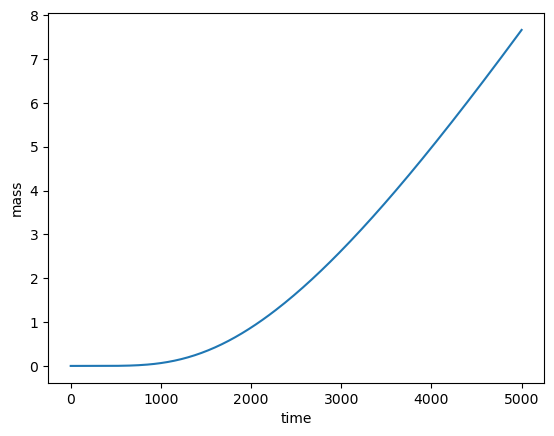

In [52]:
import matplotlib.pyplot as pyplot
pyplot.xlabel("time")
pyplot.ylabel("mass")
pyplot.plot(tPoints, mPoints)
pyplot.show()